# Import

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torch.nn.functional as F



# Load the data

In [2]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        X = data_dict[b'data']
        Y = data_dict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y
    
def load_training_data():
    X_train = []
    Y_train = []
    for i in range(1, 6):
        filename = f'./data_batch_{i}'  
        X, Y = load_batch(filename)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    return X_train, Y_train

def load_test_data():
    filename = './test_batch'
    X_test, Y_test = load_batch(filename)
    return X_test, Y_test


# Display the data

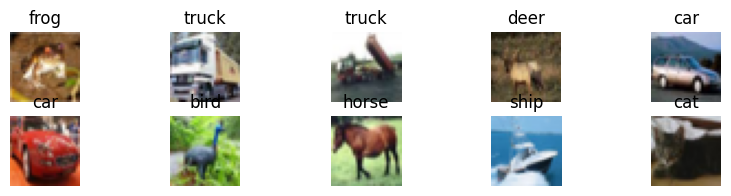

In [5]:
# CIFAR-10 category labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Display the first 10 images
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.title(classes[Y_train[i]])
    plt.axis('off')
plt.show()

# Data preprocessing

In [7]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Creating a Data Loader
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# CNN

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss=1.5907, Train Acc=43.20%, Val Loss=1.3535, Val Acc=52.61%
Epoch 2: Train Loss=1.2622, Train Acc=55.91%, Val Loss=1.2096, Val Acc=57.70%
Epoch 3: Train Loss=1.1405, Train Acc=60.33%, Val Loss=1.1197, Val Acc=61.23%
Epoch 4: Train Loss=1.0584, Train Acc=63.34%, Val Loss=1.1085, Val Acc=61.19%
Epoch 5: Train Loss=1.0047, Train Acc=65.23%, Val Loss=1.0477, Val Acc=63.80%
Epoch 6: Train Loss=0.9564, Train Acc=66.94%, Val Loss=1.0145, Val Acc=64.74%
Epoch 7: Train Loss=0.9167, Train Acc=68.22%, Val Loss=0.9948, Val Acc=65.92%
Epoch 8: Train Loss=0.8882, Train Acc=69.30%, Val Loss=0.9885, Val Acc=65.78%
Epoch 9: Train Loss=0.8544, Train Acc=70.67%, Val Loss=0.9575, Val Acc=67.37%
Epoch 10: Train Loss=0.8321, Train Acc=71.31%, Val Loss=0.9513, Val Acc=67.29%


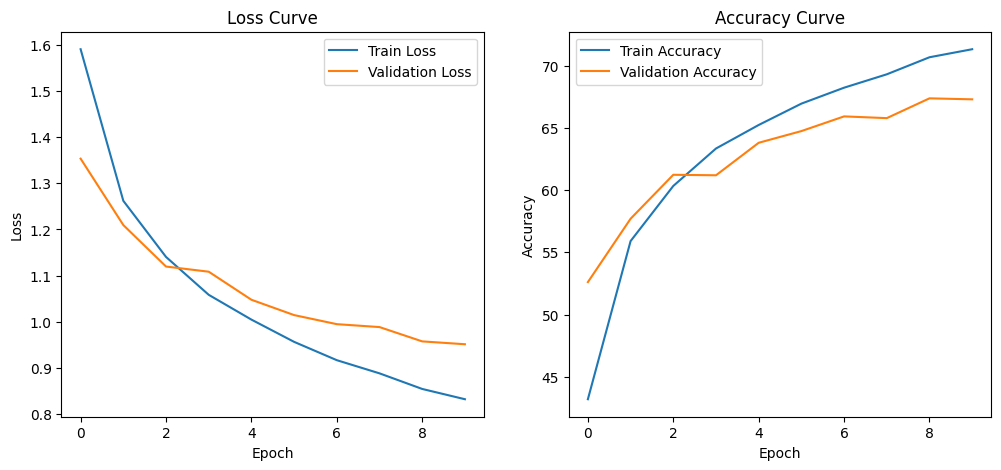

In [8]:
# Defining CNN Models
class CNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        return x

# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation with recording of losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(10):
    # Training mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # verification mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss=1.5748, Train Acc=44.37%, Val Loss=1.3181, Val Acc=53.37%
Epoch 2: Train Loss=1.2324, Train Acc=56.67%, Val Loss=1.1768, Val Acc=58.78%
Epoch 3: Train Loss=1.1078, Train Acc=61.19%, Val Loss=1.1017, Val Acc=61.89%
Epoch 4: Train Loss=1.0260, Train Acc=64.55%, Val Loss=1.0509, Val Acc=63.16%
Epoch 5: Train Loss=0.9639, Train Acc=66.87%, Val Loss=1.0057, Val Acc=65.48%
Epoch 6: Train Loss=0.9206, Train Acc=68.33%, Val Loss=0.9783, Val Acc=66.44%
Epoch 7: Train Loss=0.8748, Train Acc=70.13%, Val Loss=0.9728, Val Acc=66.68%
Epoch 8: Train Loss=0.8489, Train Acc=70.92%, Val Loss=0.9476, Val Acc=67.39%
Epoch 9: Train Loss=0.8185, Train Acc=71.81%, Val Loss=0.9414, Val Acc=67.71%
Epoch 10: Train Loss=0.7956, Train Acc=72.64%, Val Loss=0.9428, Val Acc=67.66%
Epoch 11: Train Loss=0.7716, Train Acc=73.49%, Val Loss=0.9391, Val Acc=67.93%
Epoch 12: Train Loss=0.7574, Train Acc=73.93%, Val Loss=0.9246, 

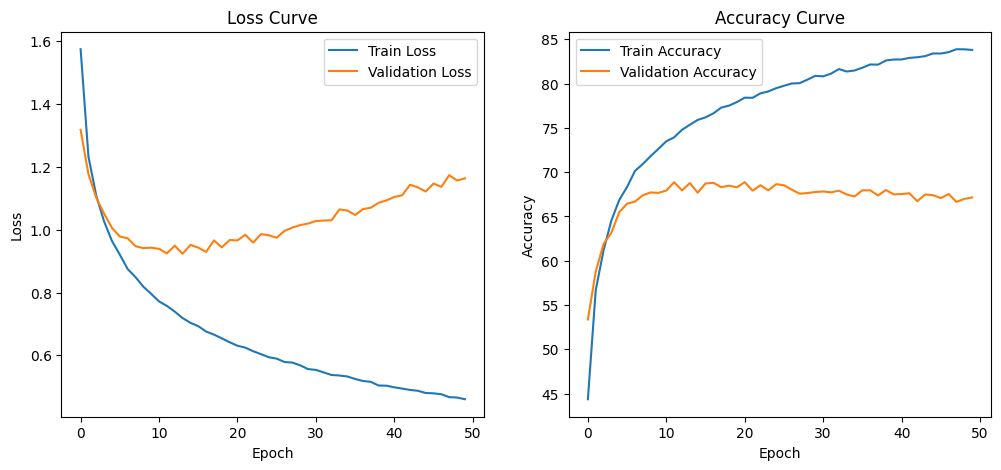

In [9]:
# Defining CNN Models
class CNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        return x

# data loader
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
valloader = DataLoader(valset, batch_size=100, shuffle=False)

# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):  # Set epoch as 50
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # verification mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss=1.7810, Train Acc=35.40%, Val Loss=1.5606, Val Acc=43.09%
Epoch 2: Train Loss=1.5451, Train Acc=43.80%, Val Loss=1.4502, Val Acc=47.35%
Epoch 3: Train Loss=1.4594, Train Acc=47.29%, Val Loss=1.3882, Val Acc=50.57%
Epoch 4: Train Loss=1.3988, Train Acc=49.44%, Val Loss=1.3181, Val Acc=53.37%
Epoch 5: Train Loss=1.3547, Train Acc=51.57%, Val Loss=1.2804, Val Acc=55.02%
Epoch 6: Train Loss=1.3177, Train Acc=53.04%, Val Loss=1.2323, Val Acc=57.12%
Epoch 7: Train Loss=1.2918, Train Acc=53.95%, Val Loss=1.2087, Val Acc=58.20%
Epoch 8: Train Loss=1.2737, Train Acc=54.73%, Val Loss=1.1954, Val Acc=58.63%
Epoch 9: Train Loss=1.2493, Train Acc=55.57%, Val Loss=1.1861, Val Acc=58.90%
Epoch 10: Train Loss=1.2248, Train Acc=56.45%, Val Loss=1.1463, Val Acc=59.67%
Epoch 11: Train Loss=1.2124, Train Acc=57.13%, Val Loss=1.1189, Val Acc=61.23%
Epoch 12: Train Loss=1.1941, Train Acc=57.59%, Val Loss=1.1066, 

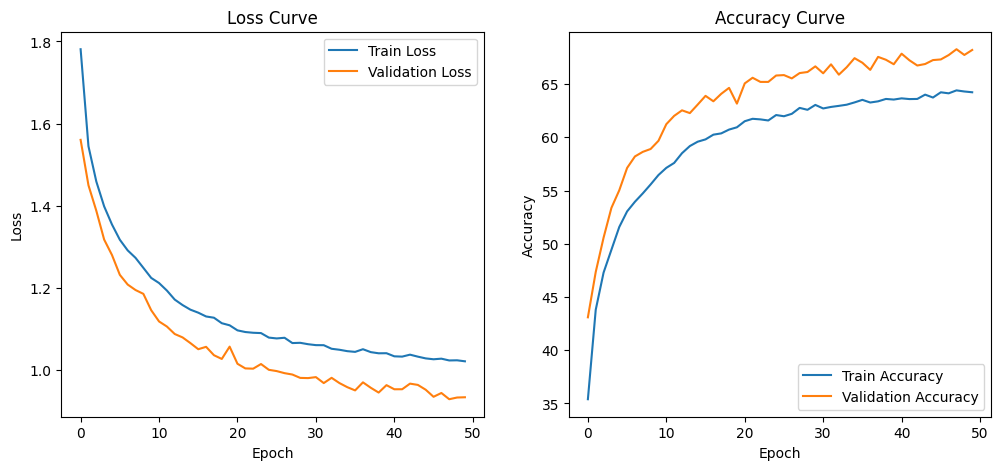

In [10]:
# Define simple CNN model, add Dropout layer
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

# Data loading and pre-processing, incorporating data enhancements
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomCrop(32, padding=4),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation with recording of losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(50): 
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # validation mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
